In [1]:
#hide
#skip
%config Completer.use_jedi = False
%config IPCompleter.greedy=True
# upgrade fastrl on colab
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [2]:
#|default_exp fastai.vision.core
#|default_cls_lvl 3

In [3]:
#|export
from __future__ import annotations
from fastrl.fastai.torch_basics import *
# from fastai.data.all import *

from PIL import Image

In [4]:
from fastrl.fastai.data.external import *

In [5]:
#|hide
from nbdev.showdoc import *

In [6]:
#|export
_all_ = ['Image','ToTensor']

In [7]:
#It didn't use to be necessary to add ToTensor in all but we don't have the encodes methods defined here otherwise.
#TODO: investigate

# Core vision
> Basic image opening/processing functionality

## Helpers

In [8]:
#|export
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
cifar_stats    = ([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
mnist_stats    = ([0.131], [0.308])

In [9]:
im = Image.open(TEST_IMAGE).resize((30,20))

In [10]:
#|export
if not hasattr(Image,'_patched'):
    _old_sz = Image.Image.size.fget
    @patch(as_prop=True)
    def size(x:Image.Image): return fastuple(_old_sz(x))
    Image._patched = True

In [11]:
#|export
@patch(as_prop=True)
def n_px(x: Image.Image): return x.size[0] * x.size[1]

#### `Image.n_px`

> `Image.n_px` (property)

Number of pixels in image

In [12]:
test_eq(im.n_px, 30*20)

In [13]:
#|export
@patch(as_prop=True)
def shape(x: Image.Image): return x.size[1],x.size[0]

#### `Image.shape`

> `Image.shape` (property)

Image (height,width) tuple (NB: opposite order of `Image.size()`, same order as numpy array and pytorch tensor)

In [14]:
test_eq(im.shape, (20,30))

In [15]:
#|export
@patch(as_prop=True)
def aspect(x: Image.Image): return x.size[0]/x.size[1]

#### `Image.aspect`

> `Image.aspect` (property)

Aspect ratio of the image, i.e. `width/height`

In [16]:
test_eq(im.aspect, 30/20)

In [17]:
#|export
@patch
def reshape(x: Image.Image, h, w, resample=0):
    "`resize` `x` to `(w,h)`"
    return x.resize((w,h), resample=resample)

In [18]:
show_doc(Image.Image.reshape)

<h4 id="Image.reshape" class="doc_header"><code>Image.reshape</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Image.reshape</code>(**`x`**:`Image.Image`, **`h`**, **`w`**, **`resample`**=*`0`*)

`resize` `x` to `(w,h)`

In [19]:
test_eq(im.reshape(12,10).shape, (12,10))

In [20]:
#|export
@patch
def to_bytes_format(im:Image.Image, format='png'):
    "Convert to bytes, default to PNG format"
    arr = io.BytesIO()
    im.save(arr, format=format)
    return arr.getvalue()

In [21]:
show_doc(Image.Image.to_bytes_format)

<h4 id="Image.to_bytes_format" class="doc_header"><code>Image.to_bytes_format</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Image.to_bytes_format</code>(**`im`**:`Image.Image`, **`format`**=*`'png'`*)

Convert to bytes, default to PNG format

In [22]:
#|export
@patch
def to_thumb(self:Image.Image, h, w=None):
    "Same as `thumbnail`, but uses a copy"
    if w is None: w=h
    im = self.copy()
    im.thumbnail((w,h))
    return im

In [23]:
show_doc(Image.Image.to_thumb)

<h4 id="Image.to_thumb" class="doc_header"><code>Image.to_thumb</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Image.to_thumb</code>(**`h`**, **`w`**=*`None`*)

Same as `thumbnail`, but uses a copy

In [24]:
#|export
@patch
def resize_max(x: Image.Image, resample=0, max_px=None, max_h=None, max_w=None):
    "`resize` `x` to `max_px`, or `max_h`, or `max_w`"
    h,w = x.shape
    if max_px and x.n_px>max_px: h,w = fastuple(h,w).mul(math.sqrt(max_px/x.n_px))
    if max_h and h>max_h: h,w = (max_h    ,max_h*w/h)
    if max_w and w>max_w: h,w = (max_w*h/w,max_w    )
    return x.reshape(round(h), round(w), resample=resample)

In [25]:
test_eq(im.resize_max(max_px=20*30).shape, (20,30))
test_eq(im.resize_max(max_px=300).n_px, 294)
test_eq(im.resize_max(max_px=500, max_h=10, max_w=20).shape, (10,15))
test_eq(im.resize_max(max_h=14, max_w=15).shape, (10,15))
test_eq(im.resize_max(max_px=300, max_h=10, max_w=25).shape, (10,15))

In [26]:
show_doc(Image.Image.resize_max)

<h4 id="Image.resize_max" class="doc_header"><code>Image.resize_max</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Image.resize_max</code>(**`x`**:`Image.Image`, **`resample`**=*`0`*, **`max_px`**=*`None`*, **`max_h`**=*`None`*, **`max_w`**=*`None`*)

`resize` `x` to `max_px`, or `max_h`, or `max_w`

## Basic types

This section regroups the basic types used in vision with the transform that create objects of those types.

In [27]:
#|export
def to_image(x):
    "Convert a tensor or array to a PIL int8 Image"
    if isinstance(x,Image.Image): return x
    if isinstance(x,Tensor): x = to_np(x.permute((1,2,0)))
    if x.dtype==np.float32: x = (x*255).astype(np.uint8)
    return Image.fromarray(x, mode=['RGB','CMYK'][x.shape[0]==4])

In [28]:
#|export
def load_image(fn, mode=None):
    "Open and load a `PIL.Image` and convert to `mode`"
    im = Image.open(fn)
    im.load()
    im = im._new(im.im)
    return im.convert(mode) if mode else im

In [29]:
#|export
def image2tensor(img):
    "Transform image to byte tensor in `c*h*w` dim order."
    res = tensor(img)
    if res.dim()==2: res = res.unsqueeze(-1)
    return res.permute(2,0,1)

In [30]:
#|export
class PILBase(Image.Image, metaclass=BypassNewMeta):
    _bypass_type=Image.Image
    _show_args = {'cmap':'viridis'}
    _open_args = {'mode': 'RGB'}
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray,bytes), **kwargs)->None:
        "Open an `Image` from path `fn`"
        if isinstance(fn,TensorImage): fn = fn.permute(1,2,0).type(torch.uint8)
        if isinstance(fn, TensorMask): fn = fn.type(torch.uint8)
        if isinstance(fn,Tensor): fn = fn.numpy()
        if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): fn = io.BytesIO(fn)
        return cls(load_image(fn, **merge(cls._open_args, kwargs)))

    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))

    def __repr__(self): return f'{self.__class__.__name__} mode={self.mode} size={"x".join([str(d) for d in self.size])}'

In [31]:
#|export
class PILImage(PILBase): pass

In [32]:
#|export
class PILImageBW(PILImage): _show_args,_open_args = {'cmap':'Greys'},{'mode': 'L'}

In [33]:
im = PILImage.create(TEST_IMAGE)
test_eq(type(im), PILImage)
test_eq(im.mode, 'RGB')
test_eq(str(im), 'PILImage mode=RGB size=1200x803')

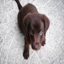

In [34]:
im.resize((64,64))

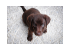

In [35]:
ax = im.show(figsize=(1,1))

In [36]:
test_fig_exists(ax)

In [37]:
timg = TensorImage(image2tensor(im))
tpil = PILImage.create(timg)

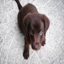

In [38]:
tpil.resize((64,64))

In [39]:
#|hide
test_eq(np.array(im), np.array(tpil))

In [40]:
#|export
class PILMask(PILBase): _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'tab20'}

In [41]:
im = PILMask.create(TEST_IMAGE)
test_eq(type(im), PILMask)
test_eq(im.mode, 'L')
test_eq(str(im), 'PILMask mode=L size=1200x803')

In [42]:
#|export
OpenMask = Transform(PILMask.create)
OpenMask.loss_func = CrossEntropyLossFlat(axis=1)
PILMask.create = OpenMask

NameError: name 'CrossEntropyLossFlat' is not defined

# Export -

In [ ]:
#|hide
from nbdev.export import notebook2script
notebook2script()